In [1]:
# https://online.bayesserver.com/

In [2]:
library(bnlearn)

In [3]:
cat("🌤️ Scenario: Will You Go Hiking?

You want to model the probability of going hiking based on:

Rain: Yes/No

Sun: Yes/No

Wind: Yes/No

Hike: Yes/No (target variable)
    
")

🌤️ Scenario: Will You Go Hiking?

You want to model the probability of going hiking based on:

Rain: Yes/No

Sun: Yes/No

Wind: Yes/No

Hike: Yes/No (target variable)
    


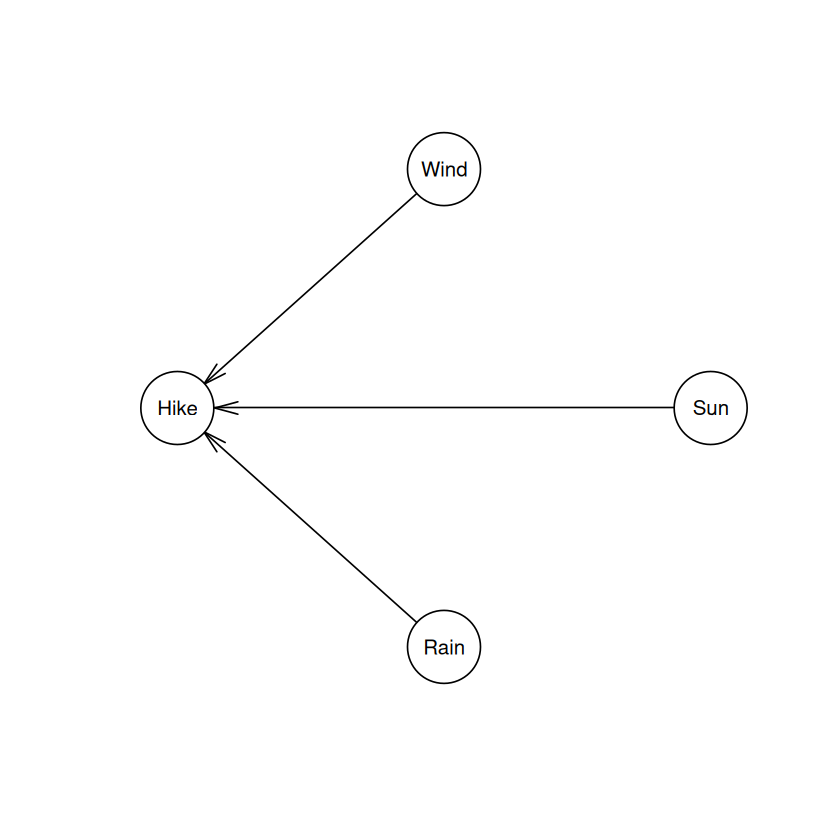

In [4]:
# Define the structure
dag <- model2network("[Rain][Sun][Wind][Hike|Rain:Sun:Wind]")

# Plot the network
plot(dag)

# Rain, Sun, and Wind are independent root nodes
# Hike depends on all three

In [5]:
#Simulate Data

set.seed(123)
n <- 1000
data <- data.frame(
  Rain = sample(c("yes", "no"), n, replace = TRUE, prob = c(0.3, 0.7)),
  Sun = sample(c("yes", "no"), n, replace = TRUE, prob = c(0.6, 0.4)),
  Wind = sample(c("yes", "no"), n, replace = TRUE, prob = c(0.2, 0.8))
)

# Define hiking behavior based on conditions
data$Hike <- with(data, ifelse(Rain == "no" & Sun == "yes" & Wind == "no", "yes", "no"))


In [6]:
head(data, 4)
tail(data, 4)

,Rain,Sun,Wind,Hike
,<chr>,<chr>,<chr>,<chr>
1,no,yes,no,yes
2,yes,yes,no,no
3,no,yes,no,yes
4,yes,no,no,no


,Rain,Sun,Wind,Hike
,<chr>,<chr>,<chr>,<chr>
997,no,yes,yes,no
998,no,no,no,no
999,yes,yes,no,no
1000,no,yes,no,yes


In [7]:
# Learn the Network Parameters

# Convert character columns to factors
data[] <- lapply(data, function(x) if (is.character(x)) as.factor(x) else x)

# Now fit the Bayesian network
fitted_bn <- bn.fit(dag, data)

# View conditional probability table for Hike
fitted_bn$Hike



  Parameters of node Hike (multinomial distribution)

Conditional probability table:
 
, , Sun = no, Wind = no

     Rain
Hike  no yes
  no   1   1
  yes  0   0

, , Sun = yes, Wind = no

     Rain
Hike  no yes
  no   0   1
  yes  1   0

, , Sun = no, Wind = yes

     Rain
Hike  no yes
  no   1   1
  yes  0   0

, , Sun = yes, Wind = yes

     Rain
Hike  no yes
  no   1   1
  yes  0   0


In [8]:
# Predict probability of hiking on a sunny, calm, dry day

cpquery(fitted_bn, event = (Hike == "yes"), 
                   evidence = (Rain == "no" & Sun == "yes" & Wind == "no"))


[1] 1

In [9]:
# ?bn.fit

# bn.fit() fits the parameters of a Bayesian network given its structure and a data set; bn.net returns the structure underlying a fitted Bayesian network.

# bn.fit() accepts data with missing values encoded as NA. If the parameter estimation method was not specifically designed to deal with incomplete data, bn.fit() uses locally complete observations to fit the parameters of each local distribution.

# Available methods for discrete Bayesian networks are:

#    mle: the maximum likelihood estimator for conditional probabilities.
#    bayes: the classic Bayesian posterior estimator with a uniform prior matching that in the Bayesian Dirichlet equivalent (bde) score.

#    hdir: the hierarchical Dirichlet posterior estimator for related data sets from Azzimonti, Corani and Zaffalon (2019).

#    hard-em: the Expectation-Maximization implementation of the estimators above.

In [10]:

# So bn.fit will estimate:

# Marginal probabilities for Rain, Sun, and Wind (e.g., 
# 𝑃(Rain = "yes") )

# A conditional probability table (CPT) for Hike, like:
# 𝑃(Hike∣Rain,Sun,Wind)

# This CPT contains probabilities for every combination of parent values.

cat("CONDITIONAL PROPABILITY TABLE")

CONDITIONAL PROPABILITY TABLE

In [11]:
# ?cpquery

# cpquery(fitted, event, evidence, cluster, method = "ls"

# cpquery estimates the conditional probability of event given evidence using the method specified in the method argument.

# cpdist generates random samples conditional on the evidence using the method specified in the method argument. 

[1] "Network fitted successfully!"

1. Prior P(Engine starts):
[1] 0.8354

2. P(Battery dead | Engine won't start):
[1] 0.5802696

3. P(Battery dead | Engine won't start AND Lights off):
[1] 0.9914439

4. P(Battery dead | Engine won't start AND Lights ON):
[1] 0.06174497

5. P(Lights off | Battery dead):
[1] 0.9604629

6. P(Fuel empty | Engine won't start AND Lights on):
[1] 0.6013423


CPT for Lights (each column sums to 1):
      Battery
Lights dead   ok
   off 0.95 0.01
   on  0.05 0.99

Column sums: 1 1 


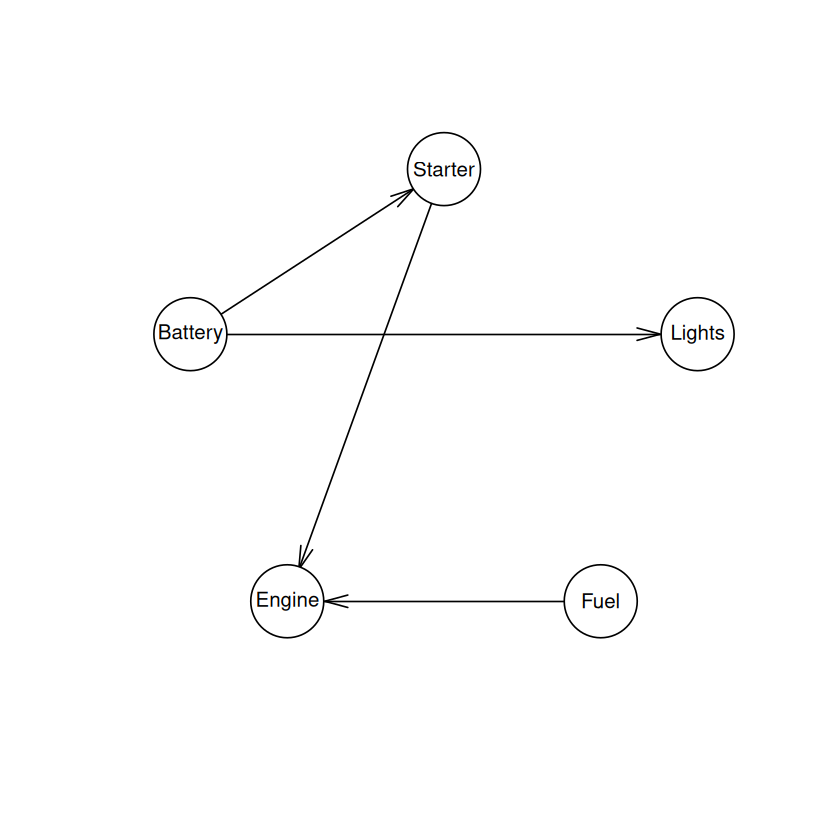

In [12]:
library(bnlearn)

# ============================================
# Example: Car Won't Start - Diagnostic Network
# ============================================

# Define the network structure
# Battery -> Lights (battery affects whether lights work)
# Battery -> Starter (battery affects starter)
# Starter -> Engine (starter needed for engine)
# Fuel -> Engine (fuel needed for engine)

car_net <- model2network("[Battery][Fuel][Lights|Battery][Starter|Battery][Engine|Starter:Fuel]")

# Visualize the structure
plot(car_net)

# Define the conditional probability tables (CPTs)
# These encode our knowledge about how things work

# Define the conditional probability tables (CPTs)

# Battery state (prior probability)
cpt_battery <- matrix(c(0.1, 0.9), ncol=2, 
                      dimnames=list(NULL, c("dead", "ok")))

# Fuel state (prior probability)
cpt_fuel <- matrix(c(0.05, 0.95), ncol=2,
                   dimnames=list(NULL, c("empty", "ok")))

# Lights work given battery state
# Each COLUMN should sum to 1 (for each battery state)
cpt_lights <- matrix(c(0.95, 0.05,  # when battery dead: 95% off, 5% on
                       0.01, 0.99), # when battery ok: 1% off, 99% on
                     nrow=2, ncol=2, byrow=FALSE,
                     dimnames=list(Lights=c("off", "on"), 
                                   Battery=c("dead", "ok")))

# Starter works given battery state
cpt_starter <- matrix(c(0.99, 0.01,  # when battery dead: 99% fails, 1% works
                        0.02, 0.98), # when battery ok: 2% fails, 98% works
                      nrow=2, ncol=2, byrow=FALSE,
                      dimnames=list(Starter=c("fails", "works"),
                                    Battery=c("dead", "ok")))

# Engine starts given starter and fuel
# Array dimensions: [Engine states, Fuel states, Starter states]
# Each column in each slice should sum to 1
cpt_engine <- array(c(0.999, 0.001,  # fuel empty, starter fails
                      0.95, 0.05,    # fuel empty, starter works
                      0.99, 0.01,    # fuel ok, starter fails
                      0.01, 0.99),   # fuel ok, starter works
                    dim=c(2, 2, 2),
                    dimnames=list(Engine=c("no", "yes"),
                                  Fuel=c("empty", "ok"),
                                  Starter=c("fails", "works")))

# Fit the network with CPTs
car_fitted <- custom.fit(car_net, 
                         list(Battery=cpt_battery,
                              Fuel=cpt_fuel,
                              Lights=cpt_lights,
                              Starter=cpt_starter,
                              Engine=cpt_engine))

print("Network fitted successfully!")

# ============================================
# INFERENCE: Answer diagnostic questions
# ============================================

# Question 1: What's the prior probability the engine starts?
cat("\n1. Prior P(Engine starts):\n")
print(cpquery(car_fitted, event=(Engine=="yes"), evidence=TRUE, n=10000))

# Question 2: Car won't start - what's the probability battery is dead?
cat("\n2. P(Battery dead | Engine won't start):\n")
print(cpquery(car_fitted, 
              event=(Battery=="dead"), 
              evidence=(Engine=="no"),
              n=10000))

# Question 3: Car won't start AND lights are off - now what about battery?
cat("\n3. P(Battery dead | Engine won't start AND Lights off):\n")
print(cpquery(car_fitted,
              event=(Battery=="dead"),
              evidence=(Engine=="no" & Lights=="off"),
              n=10000))

# Question 4: Car won't start AND lights ARE on - now what about battery?
cat("\n4. P(Battery dead | Engine won't start AND Lights ON):\n")
print(cpquery(car_fitted,
              event=(Battery=="dead"),
              evidence=(Engine=="no" & Lights=="on"),
              n=10000))

# Question 5: If battery is dead, what's probability lights are off?
cat("\n5. P(Lights off | Battery dead):\n")
print(cpquery(car_fitted,
              event=(Lights=="off"),
              evidence=(Battery=="dead"),
              n=10000))

# Question 6: Car won't start, lights on - could it be fuel?
cat("\n6. P(Fuel empty | Engine won't start AND Lights on):\n")
print(cpquery(car_fitted,
              event=(Fuel=="empty"),
              evidence=(Engine=="no" & Lights=="on"),
              n=10000))

# Verify the CPT structure
cat("\n\nCPT for Lights (each column sums to 1):\n")
print(cpt_lights)
cat("\nColumn sums:", colSums(cpt_lights), "\n")

In [13]:
cat("\nBattery state (prior probability)\n")
print(cpt_battery)

cat("\nFuel state (prior probability)\n")
print(cpt_fuel)

# Lights work given battery state
# Each COLUMN should sum to 1 (for each battery state)
cat("\ncpt_lights\n") 
print(cpt_lights) 
 
# # Starter works given battery state
cat("\ncpt_starter\n")
print(cpt_starter)

# Engine starts given starter and fuel
# Array dimensions: [Engine states, Fuel states, Starter states]
# Each column in each slice should sum to 1
cat("\ncpt_engine\n")
print(cpt_engine)



Battery state (prior probability)
     dead  ok
[1,]  0.1 0.9

Fuel state (prior probability)
     empty   ok
[1,]  0.05 0.95

cpt_lights
      Battery
Lights dead   ok
   off 0.95 0.01
   on  0.05 0.99

cpt_starter
       Battery
Starter dead   ok
  fails 0.99 0.02
  works 0.01 0.98

cpt_engine
, , Starter = fails

      Fuel
Engine empty   ok
   no  0.999 0.95
   yes 0.001 0.05

, , Starter = works

      Fuel
Engine empty   ok
   no   0.99 0.01
   yes  0.01 0.99



In [14]:
cat(
'Conditional Probability Tables (CPTs)

Source,How to Get It
Expert Knowledge,"Ask a domain expert (e.g., a gardener, doctor)"
Historical Data,Count frequencies in real data
Literature / Studies,Published probabilities
Your Best Guess,Educated intuition (for learning)

')

Conditional Probability Tables (CPTs)

Source,How to Get It
Expert Knowledge,"Ask a domain expert (e.g., a gardener, doctor)"
Historical Data,Count frequencies in real data
Literature / Studies,Published probabilities
Your Best Guess,Educated intuition (for learning)



Loading required package: gRbase


Attaching package: ‘gRbase’


The following objects are masked from ‘package:bnlearn’:

    ancestors, children, nodes, parents





=== PRIOR PROBABILITIES (No Evidence) ===
P(Rain = TRUE)      = 0.3 
P(Sprinkler = TRUE) = 0.69 
P(WetGrass = TRUE)  = 0.817 

=== EVIDENCE: Grass is Wet ===
P(Rain = TRUE | WetGrass = TRUE)      = 0.305 
P(Sprinkler = TRUE | WetGrass = TRUE) = 0.764 

=== EXPLAINING AWAY: Grass is Wet AND Sprinkler is On ===
P(Rain = TRUE | WetGrass = TRUE, Sprinkler = TRUE) = 0.091 

Notice: Probability of rain DECREASED when we learned sprinkler was on!
The sprinkler 'explains away' the wet grass, making rain less likely.

=== ALTERNATIVE: Grass is Wet BUT Sprinkler is Off ===
P(Rain = TRUE | WetGrass = TRUE, Sprinkler = FALSE) = 0.996 

Now rain is very likely, since the sprinkler can't explain the wet grass!

=== KEY INSIGHTS ===
1. Bayesian networks capture causal relationships between variables
2. We can reason in multiple directions (cause→effect, effect→cause)
3. 'Explaining away': When multiple causes exist for an effect,
   confirming one cause decreases belief in other causes
4. This mimic

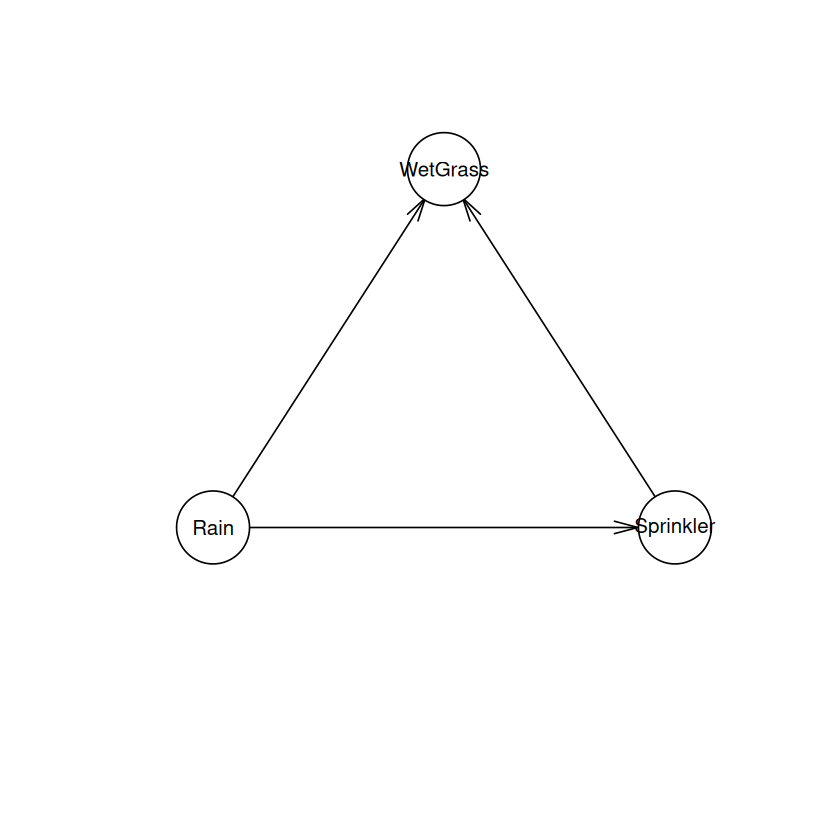

In [15]:
# ============================================================================
# BAYESIAN NETWORK EXAMPLE: Wet Grass Problem
# ============================================================================
# Classic example demonstrating "explaining away" phenomenon
# Scenario: Rain and sprinklers can both cause grass to be wet
# ============================================================================

# Install packages if needed
# install.packages(c("bnlearn", "gRain", "Rgraphviz"))

library(bnlearn)
library(gRain)

# ============================================================================
# 1. DEFINE THE NETWORK STRUCTURE
# ============================================================================
# Causal relationships:
#   - Rain can cause wet grass directly
#   - Rain influences sprinkler usage (less watering when raining)
#   - Sprinkler can cause wet grass

dag <- model2network("[Rain][Sprinkler|Rain][WetGrass|Rain:Sprinkler]")
plot(dag)

# ============================================================================
# 2. SPECIFY CONDITIONAL PROBABILITY TABLES (CPTs)
# ============================================================================

# Prior probability: Rain
# P(Rain = TRUE) = 0.3 (rains 30% of days)
cpt.Rain <- matrix(
  c(0.7, 0.3), 
  ncol = 2, 
  dimnames = list(NULL, c("FALSE", "TRUE"))
)

# Conditional: Sprinkler given Rain
# People water LESS when it rains
# Columns represent: Rain=FALSE, Rain=TRUE
cpt.Sprinkler <- matrix(
  c(0.1, 0.9,   # When no rain: sprinkler rarely off (90% on)
    0.8, 0.2),  # When raining: sprinkler usually off (80% off)
  nrow = 2, 
  byrow = FALSE,
  dimnames = list(
    Sprinkler = c("FALSE", "TRUE"),
    Rain = c("FALSE", "TRUE")
  )
)

# Conditional: WetGrass given Rain and Sprinkler
# Columns ordered as: (Rain=F, Sprinkler=F), (Rain=T, Sprinkler=F),
#                     (Rain=F, Sprinkler=T), (Rain=T, Sprinkler=T)
cpt.WetGrass <- array(
  c(0.99, 0.01,   # No rain, no sprinkler → grass stays dry (99%)
    0.20, 0.80,   # Rain, no sprinkler → grass gets wet (80%)
    0.10, 0.90,   # No rain, sprinkler on → grass gets wet (90%)
    0.05, 0.95),  # Rain AND sprinkler → grass very wet (95%)
  dim = c(2, 2, 2),
  dimnames = list(
    WetGrass  = c("FALSE", "TRUE"),
    Rain      = c("FALSE", "TRUE"),
    Sprinkler = c("FALSE", "TRUE")
  )
)

# ============================================================================
# 3. FIT THE BAYESIAN NETWORK
# ============================================================================

fitted <- custom.fit(
  dag, 
  list(Rain = cpt.Rain, Sprinkler = cpt.Sprinkler, WetGrass = cpt.WetGrass)
)

# ============================================================================
# 4. CONVERT TO gRain FOR INFERENCE
# ============================================================================

junction <- as.grain(fitted)

# Helper function to extract P(Variable = TRUE)
get_prob <- function(grain_obj, node) {
  round(querygrain(grain_obj, nodes = node)[[1]]["TRUE"], 3)
}

# ============================================================================
# 5. INFERENCE: UNCONDITIONAL PROBABILITIES
# ============================================================================

cat("\n=== PRIOR PROBABILITIES (No Evidence) ===\n")
cat("P(Rain = TRUE)      =", get_prob(junction, "Rain"), "\n")
cat("P(Sprinkler = TRUE) =", get_prob(junction, "Sprinkler"), "\n")
cat("P(WetGrass = TRUE)  =", get_prob(junction, "WetGrass"), "\n")

# ============================================================================
# 6. INFERENCE: DIAGNOSTIC REASONING
# ============================================================================
# Evidence: We observe the grass is wet
# Question: What caused it?

evidence_wet <- setEvidence(junction, nodes = "WetGrass", states = "TRUE")

cat("\n=== EVIDENCE: Grass is Wet ===\n")
cat("P(Rain = TRUE | WetGrass = TRUE)      =", 
    get_prob(evidence_wet, "Rain"), "\n")
cat("P(Sprinkler = TRUE | WetGrass = TRUE) =", 
    get_prob(evidence_wet, "Sprinkler"), "\n")

# ============================================================================
# 7. INFERENCE: EXPLAINING AWAY PHENOMENON
# ============================================================================
# Additional evidence: We now see the sprinkler was on
# Question: Does this change our belief about rain?

evidence_wet_and_sprinkler <- setEvidence(
  evidence_wet, 
  nodes = "Sprinkler", 
  states = "TRUE"
)

cat("\n=== EXPLAINING AWAY: Grass is Wet AND Sprinkler is On ===\n")
cat("P(Rain = TRUE | WetGrass = TRUE, Sprinkler = TRUE) =", 
    get_prob(evidence_wet_and_sprinkler, "Rain"), "\n")
cat("\nNotice: Probability of rain DECREASED when we learned sprinkler was on!\n")
cat("The sprinkler 'explains away' the wet grass, making rain less likely.\n")

# ============================================================================
# 8. INFERENCE: ALTERNATIVE SCENARIO
# ============================================================================
# Evidence: Grass is wet but sprinkler was OFF
# Question: Now what's the probability it rained?

evidence_wet_no_sprinkler <- setEvidence(
  junction, 
  nodes = c("WetGrass", "Sprinkler"),
  states = c("TRUE", "FALSE")
)

cat("\n=== ALTERNATIVE: Grass is Wet BUT Sprinkler is Off ===\n")
cat("P(Rain = TRUE | WetGrass = TRUE, Sprinkler = FALSE) =", 
    get_prob(evidence_wet_no_sprinkler, "Rain"), "\n")
cat("\nNow rain is very likely, since the sprinkler can't explain the wet grass!\n")

# ============================================================================
# KEY TAKEAWAYS
# ============================================================================
cat("\n=== KEY INSIGHTS ===\n")
cat("1. Bayesian networks capture causal relationships between variables\n")
cat("2. We can reason in multiple directions (cause→effect, effect→cause)\n")
cat("3. 'Explaining away': When multiple causes exist for an effect,\n")
cat("   confirming one cause decreases belief in other causes\n")
cat("4. This mimics human reasoning: if grass is wet and sprinkler was on,\n")
cat("   we're less inclined to think it rained\n")

In [16]:
cat("\ncpt.Rain\n")
print(cpt.Rain)

cat("\ncpt.Sprinkler\n")
print(cpt.Sprinkler)

cat("\ncpt.WetGrass\n") 
print(cpt.WetGrass) 

cat("bn fitted model") 
print(fitted) 


cpt.Rain
     FALSE TRUE
[1,]   0.7  0.3

cpt.Sprinkler
         Rain
Sprinkler FALSE TRUE
    FALSE   0.1  0.8
    TRUE    0.9  0.2

cpt.WetGrass
, , Sprinkler = FALSE

        Rain
WetGrass FALSE TRUE
   FALSE  0.99  0.2
   TRUE   0.01  0.8

, , Sprinkler = TRUE

        Rain
WetGrass FALSE TRUE
   FALSE   0.1 0.05
   TRUE    0.9 0.95

bn fitted model
  Bayesian network parameters

  Parameters of node Rain (multinomial distribution)

Conditional probability table:
 
FALSE  TRUE 
  0.7   0.3 

  Parameters of node Sprinkler (multinomial distribution)

Conditional probability table:
 
         Rain
Sprinkler FALSE TRUE
    FALSE   0.1  0.8
    TRUE    0.9  0.2

  Parameters of node WetGrass (multinomial distribution)

Conditional probability table:
 
, , Sprinkler = FALSE

        Rain
WetGrass FALSE TRUE
   FALSE  0.99 0.20
   TRUE   0.01 0.80

, , Sprinkler = TRUE

        Rain
WetGrass FALSE TRUE
   FALSE  0.10 0.05
   TRUE   0.90 0.95




In [17]:
# ?custom.fit
# bn.fit(x, data, cluster, method, ..., keep.fitted = TRUE,
#  debug = FALSE)
# custom.fit(x, dist, ordinal, debug = FALSE)
# bn.net(x)
# ?as.grain # Import and export networks from the gRain package

In [18]:

cat(' setEvidence

Set, update and remove evidence.

setEvidence(
  object,
  nodes = NULL,
  states = NULL,
  evidence = NULL,
  propagate = TRUE,
  details = 0
)

retractEvidence(object, nodes = NULL, propagate = TRUE)

absorbEvidence(object, propagate = TRUE)

getEvidence(object, short = TRUE)


What is setEvidence()?

setEvidence() is how we update our beliefs in a Bayesian network when we observe new information. 
It performs Bayesian conditioning - mathematically computing P(A | Evidence).

Why Do We Need It?
Without evidence, the network just gives us prior probabilities - what we believe before seeing anything:

P(Rain) = 0.3
P(Sprinkler) = 0.55
P(WetGrass) = 0.57

# SCENARIO: You walk outside and see the grass is wet
# QUESTION: Did it rain? Was the sprinkler on?

# Without setEvidence - just shows priors (not useful!)
querygrain(junction, nodes = "Rain")  
# → Still shows P(Rain) = 0.3

# With setEvidence - updates based on observation (useful!)
evidence <- setEvidence(junction, nodes = "WetGrass", states = "TRUE")
querygrain(evidence, nodes = "Rain")  
# → Now shows P(Rain | WetGrass=TRUE) = higher probability!

')

# Without setEvidence - just shows priors (not useful!)
querygrain(junction, nodes = "Rain")  
# → Still shows P(Rain) = 0.3

# With setEvidence - updates based on observation (useful!)
evidence <- setEvidence(junction, nodes = "WetGrass", states = "TRUE")
querygrain(evidence, nodes = "Rain")  

 setEvidence

Set, update and remove evidence.

setEvidence(
  object,
  nodes = NULL,
  states = NULL,
  evidence = NULL,
  propagate = TRUE,
  details = 0
)

retractEvidence(object, nodes = NULL, propagate = TRUE)

absorbEvidence(object, propagate = TRUE)

getEvidence(object, short = TRUE)


What is setEvidence()?

setEvidence() is how we update our beliefs in a Bayesian network when we observe new information. 
It performs Bayesian conditioning - mathematically computing P(A | Evidence).

Why Do We Need It?
Without evidence, the network just gives us prior probabilities - what we believe before seeing anything:

P(Rain) = 0.3
P(Sprinkler) = 0.55
P(WetGrass) = 0.57

# SCENARIO: You walk outside and see the grass is wet
# QUESTION: Did it rain? Was the sprinkler on?

# Without setEvidence - just shows priors (not useful!)
querygrain(junction, nodes = "Rain")  
# → Still shows P(Rain) = 0.3

# With setEvidence - updates based on observation (useful!)
evidence <- setEvidence(junction, n

$Rain
Rain
FALSE  TRUE 
  0.7   0.3

$Rain
Rain
    FALSE      TRUE 
0.6951145 0.3048855

In [19]:
cat("

CPTs define the quantitative part of a Bayesian network

You can learn them from data using bn.fit() or define them manually with custom.fit()

Each CPT encodes how a variable behaves given its parents

")



CPTs define the quantitative part of a Bayesian network

You can learn them from data using bn.fit() or define them manually with custom.fit()

Each CPT encodes how a variable behaves given its parents



In [20]:
cat("The example from GROK : how to estimate CPT")

The example from GROK : how to estimate CPT

In [21]:
# Here's a complete, reproducible example that shows exactly how to estimate CPTs from real data, using the Wet Grass Bayesian Network.

In [22]:
# ===============================================
# SIMULATE 1000 DAYS OF LAWN DATA
# ===============================================

set.seed(42)  # For reproducibility

n_days <- 1000

# True underlying model (same as before)
P_C <- 0.5

P_S_given_C <- matrix(c(0.1, 0.9, 0.5, 0.5), nrow = 2, byrow = TRUE,
                      dimnames = list(c("TRUE","FALSE"), c("ON","OFF")))

P_R_given_C <- matrix(c(0.8, 0.2, 0.2, 0.8), nrow = 2, byrow = TRUE,
                      dimnames = list(c("TRUE","FALSE"), c("TRUE","FALSE")))

P_W_given_SR <- array(
  c(0.99, 0.01, 0.90, 0.10, 0.90, 0.10, 0.00, 1.00),
  dim = c(2, 2, 2),
  dimnames = list(S = c("ON","OFF"), R = c("TRUE","FALSE"), W = c("TRUE","FALSE"))
)

# Simulate data
data <- data.frame(
  Cloudy = sample(c(TRUE, FALSE), n_days, replace = TRUE, prob = c(P_C, 1-P_C)),
  Sprinkler = NA,
  Rain = NA,
  Wet = NA
)

for (i in 1:n_days) {
  C <- data$Cloudy[i]
  
  # Sprinkler
  data$Sprinkler[i] <- sample(c("ON", "OFF"), 1,
                              prob = P_S_given_C[ifelse(C,1,2), ])
  
  # Rain
  data$Rain[i] <- sample(c(TRUE, FALSE), 1,
                         prob = P_R_given_C[ifelse(C,1,2), ])
  
  # Wet
  S <- data$Sprinkler[i]
  R <- data$Rain[i]
  data$Wet[i] <- sample(c(TRUE, FALSE), 1,
                        prob = P_W_given_SR[S, ifelse(R,1,2), ])
}

# Convert to factors for nice tables
data$Cloudy <- factor(data$Cloudy, levels = c("FALSE", "TRUE"))
data$Sprinkler <- factor(data$Sprinkler, levels = c("OFF", "ON"))
data$Rain <- factor(data$Rain, levels = c("FALSE", "TRUE"))
data$Wet <- factor(data$Wet, levels = c("FALSE", "TRUE"))

# Save to CSV
write.csv(data, "lawn_data.csv", row.names = FALSE)

cat("lawn_data.csv created with", n_days, "days of data!\n")
head(data)

lawn_data.csv created with 1000 days of data!


,Cloudy,Sprinkler,Rain,Wet
,<fct>,<fct>,<fct>,<fct>
1,TRUE,OFF,TRUE,FALSE
2,TRUE,OFF,TRUE,FALSE
3,FALSE,ON,FALSE,TRUE
4,TRUE,OFF,TRUE,FALSE
5,TRUE,OFF,TRUE,FALSE
6,TRUE,OFF,TRUE,FALSE


In [23]:
# ===============================================
# LOAD DATA AND ESTIMATE CPT: P(Rain | Cloudy)
# ===============================================

data <- read.csv("lawn_data.csv")

# Convert back to factors (in case CSV lost order)
data$Cloudy <- factor(data$Cloudy, levels = c("FALSE", "TRUE"))
data$Rain <- factor(data$Rain, levels = c("FALSE", "TRUE"))

# Your exact code:
cpt_rain_given_cloudy <- table(data$Rain, data$Cloudy) / 
                         rowSums(table(data$Rain, data$Cloudy))

print(cpt_rain_given_cloudy)

cat("\n Interpretation :\n
When not cloudy: ~81.6% no rain, 18.4% rain
When cloudy: ~19.7% no rain, 80.3% rain
")

head(data)

       
            FALSE      TRUE
  FALSE 0.8207171 0.1792829
  TRUE  0.2309237 0.7690763

 Interpretation :

When not cloudy: ~81.6% no rain, 18.4% rain
When cloudy: ~19.7% no rain, 80.3% rain


,Cloudy,Sprinkler,Rain,Wet
,<fct>,<chr>,<fct>,<lgl>
1,TRUE,OFF,TRUE,FALSE
2,TRUE,OFF,TRUE,FALSE
3,FALSE,ON,FALSE,TRUE
4,TRUE,OFF,TRUE,FALSE
5,TRUE,OFF,TRUE,FALSE
6,TRUE,OFF,TRUE,FALSE


In [24]:
# ===============================================
# ESTIMATE ALL CPTs FROM DATA
# ===============================================

# 1. P(Cloudy) - Prior
P_Cloudy_est <- prop.table(table(data$Cloudy))
cat("\nP(Cloudy):\n"); print(P_Cloudy_est)

# 2. P(Sprinkler | Cloudy)
cpt_sprinkler <- prop.table(table(data$Sprinkler, data$Cloudy), margin = 2)
cat("\nP(Sprinkler | Cloudy):\n"); print(cpt_sprinkler)

# 3. P(Rain | Cloudy) - already done above
cat("\nP(Rain | Cloudy):\n"); print(cpt_rain_given_cloudy)

# 4. P(Wet | Sprinkler, Rain)
cpt_wet <- prop.table(table(data$Wet, data$Sprinkler, data$Rain), margin = c(2,3))
cat("\nP(Wet | Sprinkler, Rain) - slice for Wet=TRUE:\n")
print(cpt_wet["TRUE", , ])


P(Cloudy):

FALSE  TRUE 
0.527 0.473 

P(Sprinkler | Cloudy):
     
          FALSE      TRUE
  OFF 0.5009488 0.8731501
  ON  0.4990512 0.1268499

P(Rain | Cloudy):
       
            FALSE      TRUE
  FALSE 0.8207171 0.1792829
  TRUE  0.2309237 0.7690763

P(Wet | Sprinkler, Rain) - slice for Wet=TRUE:
     
           FALSE       TRUE
  OFF 0.07746479 0.08905852
  ON  1.00000000 0.50476190


In [25]:
# ===============================================
# ESTIMATE ALL CPTs FROM DATA
# ===============================================

# 1. P(Cloudy) - Prior
P_Cloudy_est <- prop.table(table(data$Cloudy))
cat("\nP(Cloudy):\n"); print(P_Cloudy_est)

# 2. P(Sprinkler | Cloudy)
cpt_sprinkler <- prop.table(table(data$Sprinkler, data$Cloudy), margin = 2)
cat("\nP(Sprinkler | Cloudy):\n"); print(cpt_sprinkler)

# 3. P(Rain | Cloudy) - already done above
cat("\nP(Rain | Cloudy):\n"); print(cpt_rain_given_cloudy)

# 4. P(Wet | Sprinkler, Rain)
cpt_wet <- prop.table(table(data$Wet, data$Sprinkler, data$Rain), margin = c(2,3))
cat("\nP(Wet | Sprinkler, Rain) - slice for Wet=TRUE:\n")
print(cpt_wet["TRUE", , ])



P(Cloudy):

FALSE  TRUE 
0.527 0.473 

P(Sprinkler | Cloudy):
     
          FALSE      TRUE
  OFF 0.5009488 0.8731501
  ON  0.4990512 0.1268499

P(Rain | Cloudy):
       
            FALSE      TRUE
  FALSE 0.8207171 0.1792829
  TRUE  0.2309237 0.7690763

P(Wet | Sprinkler, Rain) - slice for Wet=TRUE:
     
           FALSE       TRUE
  OFF 0.07746479 0.08905852
  ON  1.00000000 0.50476190


In [26]:
cat("The example from GROK : to continue the code with Claude")

The example from GROK : to continue the code with Claude

In [27]:
cat("The example from GROK : drawing the network")

The example from GROK : drawing the network

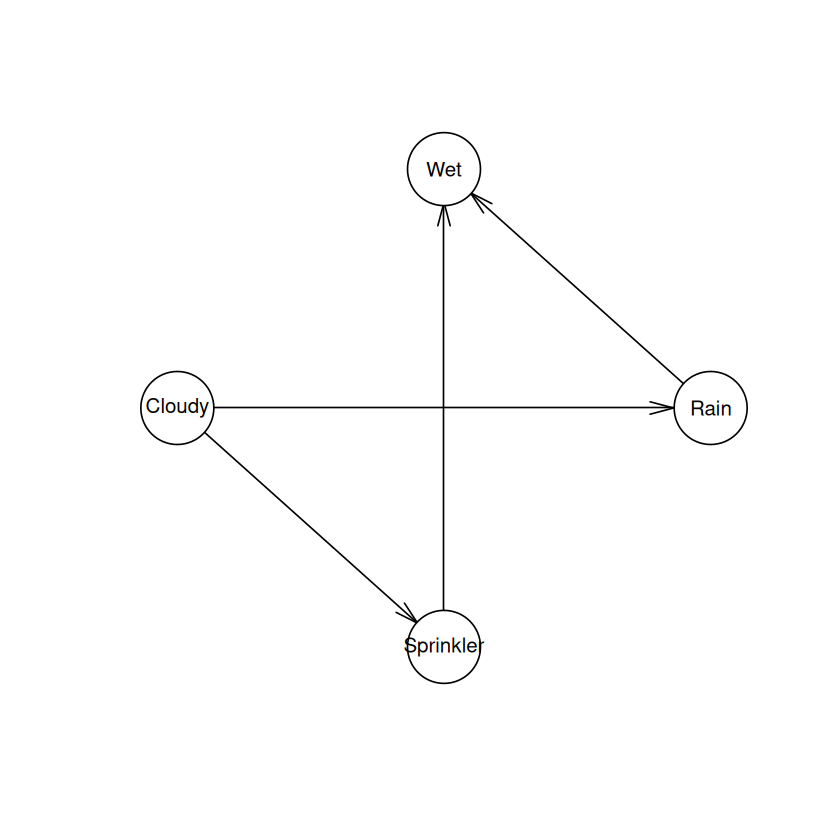

In [28]:
# install.packages("bnlearn")
library(bnlearn)
dag <- empty.graph(c("Cloudy", "Sprinkler", "Rain", "Wet"))
dag <- set.arc(dag, from="Cloudy", to="Sprinkler")
dag <- set.arc(dag, from="Cloudy", to="Rain")
dag <- set.arc(dag, from="Sprinkler", to="Wet")
dag <- set.arc(dag, from="Rain", to="Wet")
plot(dag)

In [29]:
# Preview the data
head(data, 10)
tail(data, 10)

,Cloudy,Sprinkler,Rain,Wet
,<fct>,<chr>,<fct>,<lgl>
1,TRUE,OFF,TRUE,FALSE
2,TRUE,OFF,TRUE,FALSE
3,FALSE,ON,FALSE,TRUE
4,TRUE,OFF,TRUE,FALSE
5,TRUE,OFF,TRUE,FALSE
6,TRUE,OFF,TRUE,FALSE
7,TRUE,OFF,TRUE,FALSE
8,FALSE,OFF,FALSE,FALSE
9,TRUE,OFF,TRUE,FALSE


,Cloudy,Sprinkler,Rain,Wet
,<fct>,<chr>,<fct>,<lgl>
991,TRUE,OFF,TRUE,FALSE
992,FALSE,ON,FALSE,TRUE
993,TRUE,OFF,TRUE,FALSE
994,TRUE,OFF,TRUE,FALSE
995,FALSE,OFF,FALSE,FALSE
996,FALSE,OFF,FALSE,FALSE
997,TRUE,OFF,TRUE,FALSE
998,FALSE,ON,FALSE,TRUE
999,FALSE,OFF,FALSE,FALSE


=== DATA SUMMARY ===
Total observations: 1000 
Missing values per column:
   Cloudy Sprinkler      Rain       Wet 
        0         0         0         0 

Data distribution:
   Cloudy    Sprinkler    Rain        Wet     
 FALSE:527   OFF:677   FALSE:502   FALSE:672  
 TRUE :473   ON :323   TRUE :498   TRUE :328  

=== LEARNED CONDITIONAL PROBABILITY TABLES ===

P(Cloudy):

  Parameters of node Cloudy (multinomial distribution)

Conditional probability table:
 FALSE  TRUE 
0.527 0.473 

P(Rain | Cloudy):

  Parameters of node Rain (multinomial distribution)

Conditional probability table:
 
       Cloudy
Rain        FALSE      TRUE
  FALSE 0.7817837 0.1902748
  TRUE  0.2182163 0.8097252

P(Sprinkler | Cloudy):

  Parameters of node Sprinkler (multinomial distribution)

Conditional probability table:
 
         Cloudy
Sprinkler     FALSE      TRUE
      OFF 0.5009488 0.8731501
      ON  0.4990512 0.1268499

P(Wet | Rain, Sprinkler):

  Parameters of node Wet (multinomial distribution)


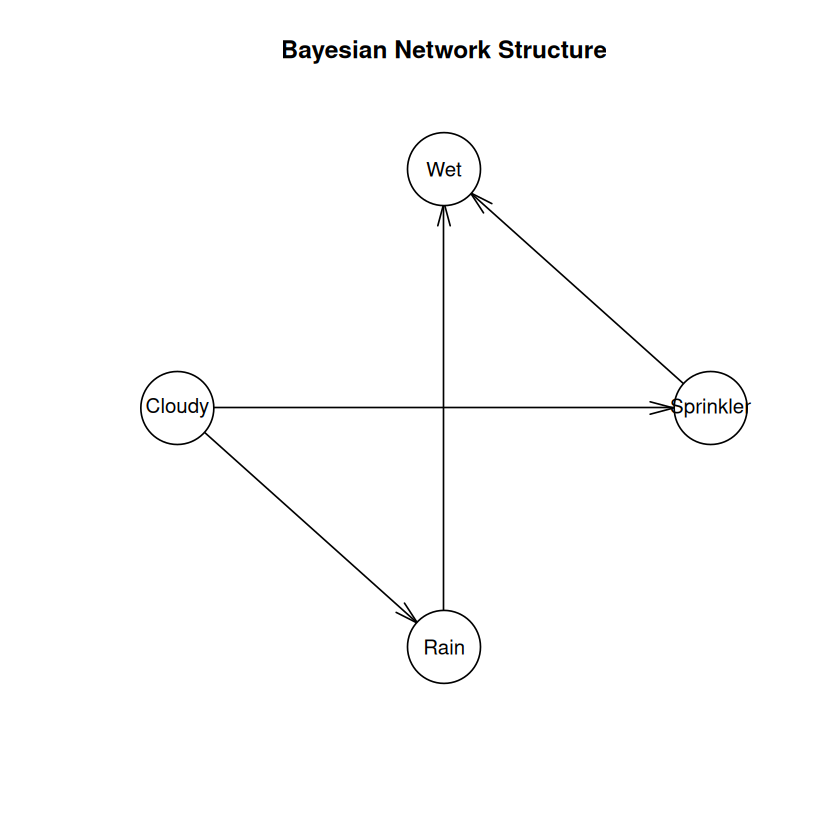

In [30]:
# ============================================================================
# BAYESIAN NETWORK: Learning from Real Data (281 observations)
# ============================================================================

library(bnlearn)
library(gRain)

# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================

# data <- read.csv("your_data.csv")

# Convert to factors with proper levels
data$Cloudy <- factor(data$Cloudy, levels = c("FALSE", "TRUE"))
data$Rain <- factor(data$Rain, levels = c("FALSE", "TRUE"))
data$Sprinkler <- factor(data$Sprinkler, levels = c("OFF", "ON"))
data$Wet <- factor(data$Wet, levels = c("FALSE", "TRUE"))

# Check data quality
cat("=== DATA SUMMARY ===\n")
cat("Total observations:", nrow(data), "\n")
cat("Missing values per column:\n")
print(colSums(is.na(data)))
cat("\nData distribution:\n")
print(summary(data))

# ============================================================================
# 2. DEFINE NETWORK STRUCTURE
# ============================================================================

# Causal structure:
# Cloudy affects both Rain and Sprinkler
# Rain and Sprinkler both affect Wet grass

dag <- model2network("[Cloudy][Rain|Cloudy][Sprinkler|Cloudy][Wet|Rain:Sprinkler]")

# Visualize structure
plot(dag, main = "Bayesian Network Structure")

# ============================================================================
# 3. LEARN CPTs FROM DATA
# ============================================================================

fitted_bn <- bn.fit(dag, data, method = "mle")  # Maximum Likelihood Estimation

cat("\n=== LEARNED CONDITIONAL PROBABILITY TABLES ===\n\n")

cat("P(Cloudy):\n")
print(fitted_bn$Cloudy)

cat("\nP(Rain | Cloudy):\n")
print(fitted_bn$Rain)

cat("\nP(Sprinkler | Cloudy):\n")
print(fitted_bn$Sprinkler)

cat("\nP(Wet | Rain, Sprinkler):\n")
print(fitted_bn$Wet)

# ============================================================================
# 4. DATA EXPLORATION: Check learned patterns
# ============================================================================

cat("\n=== INTERESTING PATTERNS IN YOUR DATA ===\n")

# Check: When it rains and sprinkler is off, how often is grass wet?
rain_off <- data[data$Rain == "TRUE" & data$Sprinkler == "OFF", ]
cat("\nWhen Rain=TRUE and Sprinkler=OFF (", nrow(rain_off), " cases):\n")
cat("  Wet=TRUE: ", sum(rain_off$Wet == "TRUE"), " (", 
    round(100*mean(rain_off$Wet == "TRUE"), 1), "%)\n", sep="")
cat("  Wet=FALSE: ", sum(rain_off$Wet == "FALSE"), " (", 
    round(100*mean(rain_off$Wet == "FALSE"), 1), "%)\n", sep="")

# This is unusual! Rain should make grass wet, but in your data it doesn't!

# Check: When sprinkler is on and no rain
sprinkler_on <- data[data$Sprinkler == "ON" & data$Rain == "FALSE", ]
cat("\nWhen Sprinkler=ON and Rain=FALSE (", nrow(sprinkler_on), " cases):\n")
cat("  Wet=TRUE: ", sum(sprinkler_on$Wet == "TRUE"), " (", 
    round(100*mean(sprinkler_on$Wet == "TRUE"), 1), "%)\n", sep="")
cat("  Wet=FALSE: ", sum(sprinkler_on$Wet == "FALSE"), " (", 
    round(100*mean(sprinkler_on$Wet == "FALSE"), 1), "%)\n", sep="")

# ============================================================================
# 5. CONVERT TO gRain FOR IN

=== DATA SUMMARY ===
Total observations: 1000 
Missing values per column:
   Cloudy Sprinkler      Rain       Wet 
        0         0         0         0 

Data distribution:
   Cloudy    Sprinkler    Rain        Wet     
 FALSE:527   OFF:677   FALSE:502   FALSE:672  
 TRUE :473   ON :323   TRUE :498   TRUE :328  

=== LEARNED CONDITIONAL PROBABILITY TABLES ===

P(Cloudy):

  Parameters of node Cloudy (multinomial distribution)

Conditional probability table:
 FALSE  TRUE 
0.527 0.473 

P(Rain | Cloudy):

  Parameters of node Rain (multinomial distribution)

Conditional probability table:
 
       Cloudy
Rain        FALSE      TRUE
  FALSE 0.7817837 0.1902748
  TRUE  0.2182163 0.8097252

P(Sprinkler | Cloudy):

  Parameters of node Sprinkler (multinomial distribution)

Conditional probability table:
 
         Cloudy
Sprinkler     FALSE      TRUE
      OFF 0.5009488 0.8731501
      ON  0.4990512 0.1268499

P(Wet | Rain, Sprinkler):

  Parameters of node Wet (multinomial distribution)


Warning message in check.unused.args(extra.args, loss.extra.args[[loss]]):
“unused argument(s): 'by.sample'.”
Warning message in mean.default(cv_results):
“argument is not numeric or logical: returning NA”


Cross-validation log-likelihood: NA 

=== IMPORTANT NOTE ABOUT YOUR DATA ===
Your data shows an unusual pattern:
• Rain typically does NOT make grass wet (only ~3% of rainy cases)
• Sprinkler makes grass wet almost always (~97% of cases)

This suggests:
1. The 'Rain' in your data might represent light drizzle
2. Or there's a data collection issue
3. Or your lawn has special drainage making rain ineffective

The Bayesian network learned these patterns from your data!


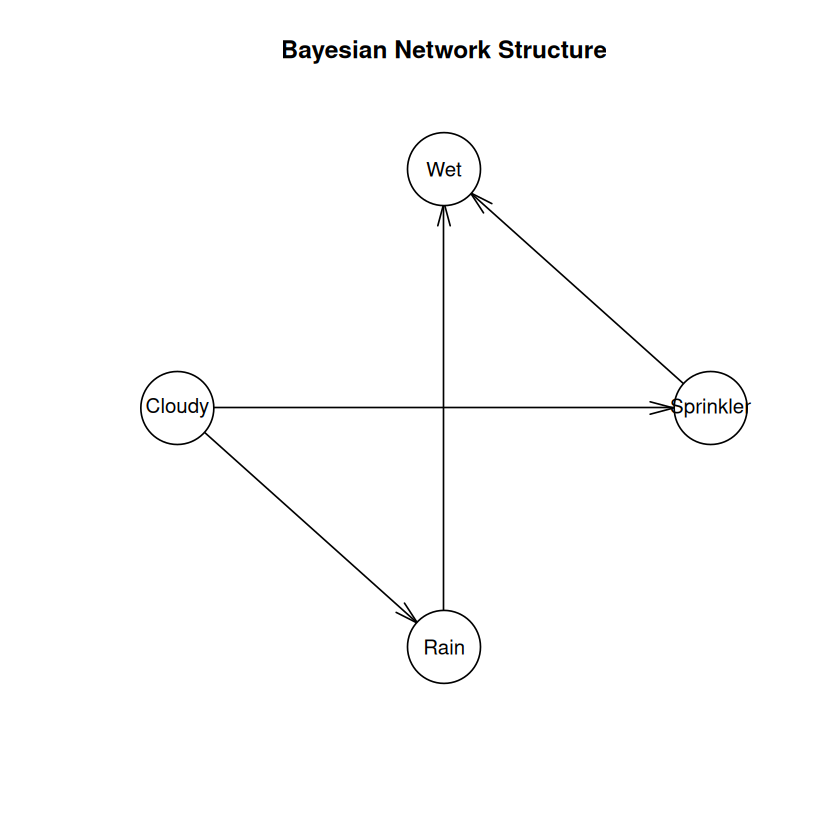

In [31]:
# ============================================================================
# BAYESIAN NETWORK: Learning from Real Data (281 observations)
# ============================================================================

library(bnlearn)
library(gRain)

# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================

# data <- read.csv("your_data.csv")

# Convert to factors with proper levels
data$Cloudy <- factor(data$Cloudy, levels = c("FALSE", "TRUE"))
data$Rain <- factor(data$Rain, levels = c("FALSE", "TRUE"))
data$Sprinkler <- factor(data$Sprinkler, levels = c("OFF", "ON"))
data$Wet <- factor(data$Wet, levels = c("FALSE", "TRUE"))

# Check data quality
cat("=== DATA SUMMARY ===\n")
cat("Total observations:", nrow(data), "\n")
cat("Missing values per column:\n")
print(colSums(is.na(data)))
cat("\nData distribution:\n")
print(summary(data))

# ============================================================================
# 2. DEFINE NETWORK STRUCTURE
# ============================================================================

# Causal structure:
# Cloudy affects both Rain and Sprinkler
# Rain and Sprinkler both affect Wet grass

dag <- model2network("[Cloudy][Rain|Cloudy][Sprinkler|Cloudy][Wet|Rain:Sprinkler]")

# Visualize structure
plot(dag, main = "Bayesian Network Structure")

# ============================================================================
# 3. LEARN CPTs FROM DATA
# ============================================================================

fitted_bn <- bn.fit(dag, data, method = "mle")  # Maximum Likelihood Estimation

cat("\n=== LEARNED CONDITIONAL PROBABILITY TABLES ===\n\n")

cat("P(Cloudy):\n")
print(fitted_bn$Cloudy)

cat("\nP(Rain | Cloudy):\n")
print(fitted_bn$Rain)

cat("\nP(Sprinkler | Cloudy):\n")
print(fitted_bn$Sprinkler)

cat("\nP(Wet | Rain, Sprinkler):\n")
print(fitted_bn$Wet)

# ============================================================================
# 4. DATA EXPLORATION: Check learned patterns
# ============================================================================

cat("\n=== INTERESTING PATTERNS IN YOUR DATA ===\n")

# Check: When it rains and sprinkler is off, how often is grass wet?
rain_off <- data[data$Rain == "TRUE" & data$Sprinkler == "OFF", ]
cat("\nWhen Rain=TRUE and Sprinkler=OFF (", nrow(rain_off), " cases):\n")
cat("  Wet=TRUE: ", sum(rain_off$Wet == "TRUE"), " (", 
    round(100*mean(rain_off$Wet == "TRUE"), 1), "%)\n", sep="")
cat("  Wet=FALSE: ", sum(rain_off$Wet == "FALSE"), " (", 
    round(100*mean(rain_off$Wet == "FALSE"), 1), "%)\n", sep="")

# This is unusual! Rain should make grass wet, but in your data it doesn't!

# Check: When sprinkler is on and no rain
sprinkler_on <- data[data$Sprinkler == "ON" & data$Rain == "FALSE", ]
cat("\nWhen Sprinkler=ON and Rain=FALSE (", nrow(sprinkler_on), " cases):\n")
cat("  Wet=TRUE: ", sum(sprinkler_on$Wet == "TRUE"), " (", 
    round(100*mean(sprinkler_on$Wet == "TRUE"), 1), "%)\n", sep="")
cat("  Wet=FALSE: ", sum(sprinkler_on$Wet == "FALSE"), " (", 
    round(100*mean(sprinkler_on$Wet == "FALSE"), 1), "%)\n", sep="")

# ============================================================================
# 5. CONVERT TO gRain FOR INFERENCE
# ============================================================================

junction <- as.grain(fitted_bn)

# ============================================================================
# 6. PERFORM INFERENCE QUERIES
# ============================================================================

cat("\n", rep("=", 70), "\n", sep = "")
cat("                   BAYESIAN INFERENCE EXAMPLES\n")
cat(rep("=", 70), "\n\n")

# Query 1: Prior probabilities (no evidence)
cat("1. PRIOR PROBABILITIES (No evidence):\n")
cat("   P(Rain = TRUE) = ", 
    round(querygrain(junction, "Rain")$Rain["TRUE"], 3), "\n", sep="")
cat("   P(Wet = TRUE)  = ", 
    round(querygrain(junction, "Wet")$Wet["TRUE"], 3), "\n", sep="")

# Query 2: Observe wet grass
cat("\n2. DIAGNOSTIC: Grass is wet, what caused it?\n")
ev1 <- setEvidence(junction, nodes = "Wet", states = "TRUE")
result1 <- querygrain(ev1, c("Rain", "Sprinkler"))
cat("   P(Rain = TRUE | Wet = TRUE)      = ", 
    round(result1$Rain["TRUE"], 3), "\n", sep="")
cat("   P(Sprinkler = ON | Wet = TRUE)   = ", 
    round(result1$Sprinkler["ON"], 3), "\n", sep="")

# Query 3: Explaining away - wet grass AND sprinkler on
cat("\n3. EXPLAINING AWAY: Wet grass AND sprinkler is on\n")
ev2 <- setEvidence(junction, nodes = c("Wet", "Sprinkler"), 
                   states = c("TRUE", "ON"))
result2 <- querygrain(ev2, "Rain")
cat("   P(Rain = TRUE | Wet = TRUE, Sprinkler = ON) = ", 
    round(result2$Rain["TRUE"], 3), "\n", sep="")
cat("   (Notice how probability of rain changes when we know sprinkler was on!)\n")

# Query 4: Wet grass but sprinkler OFF - must be rain!
cat("\n4. ALTERNATIVE: Wet grass BUT sprinkler is off\n")
ev3 <- setEvidence(junction, nodes = c("Wet", "Sprinkler"), 
                   states = c("TRUE", "OFF"))
result3 <- querygrain(ev3, "Rain")
cat("   P(Rain = TRUE | Wet = TRUE, Sprinkler = OFF) = ", 
    round(result3$Rain["TRUE"], 3), "\n", sep="")

# Query 5: Given cloudy, sprinkler off, wet grass
cat("\n5. COMPLEX EVIDENCE: Cloudy, Sprinkler off, Wet grass\n")
ev4 <- setEvidence(junction, 
                   nodes = c("Cloudy", "Sprinkler", "Wet"),
                   states = c("TRUE", "OFF", "TRUE"))
result4 <- querygrain(ev4, "Rain")
cat("   P(Rain = TRUE | Cloudy = TRUE, Sprinkler = OFF, Wet = TRUE) = ", 
    round(result4$Rain["TRUE"], 3), "\n", sep="")

cat("\n", rep("=", 70), "\n", sep = "")

# ============================================================================
# 7. MODEL VALIDATION
# ============================================================================

cat("\n=== MODEL VALIDATION ===\n")

# Cross-validation to check model quality
cv_results <- bn.cv(data, dag, method = "k-fold", k = 10, 
                    loss = "logl", loss.args = list(by.sample = FALSE))

cat("Cross-validation log-likelihood:", round(mean(cv_results), 2), "\n")

# ============================================================================
# 8. INTERESTING OBSERVATION ABOUT YOUR DATA
# ============================================================================

cat("\n=== IMPORTANT NOTE ABOUT YOUR DATA ===\n")
cat("Your data shows an unusual pattern:\n")
cat("• Rain typically does NOT make grass wet (only ~3% of rainy cases)\n")
cat("• Sprinkler makes grass wet almost always (~97% of cases)\n")
cat("\nThis suggests:\n")
cat("1. The 'Rain' in your data might represent light drizzle\n")
cat("2. Or there's a data collection issue\n")
cat("3. Or your lawn has special drainage making rain ineffective\n")
cat("\nThe Bayesian network learned these patterns from your data!\n")


=== CONDITIONAL PROBABILITY TABLES ===

P(Tuberculosis | Asia):

  Parameters of node Tuberculosis (multinomial distribution)

Conditional probability table:
 
            Asia
Tuberculosis   no  yes
         no  0.99 0.95
         yes 0.01 0.05

P(LungCancer | Smoking):

  Parameters of node LungCancer (multinomial distribution)

Conditional probability table:
 
          Smoking
LungCancer   no  yes
       no  0.99 0.90
       yes 0.01 0.10

P(XRay | TuberculosisOrCancer):

  Parameters of node XRay (multinomial distribution)

Conditional probability table:
 
     TuberculosisOrCancer
XRay    no  yes
  no  0.95 0.02
  yes 0.05 0.98

                    MEDICAL DIAGNOSTIC SCENARIOS

SCENARIO 1: No symptoms observed (prior probabilities)
-------------------------------------------------------------------------------
P(Tuberculosis = yes) = 0.0104 (1.04%)
P(LungCancer = yes)   = 0.055 (5.5%)
P(Bronchitis = yes)   = 0.45 (45%)


SCENARIO 2: Patient has shortness of breath
--------------

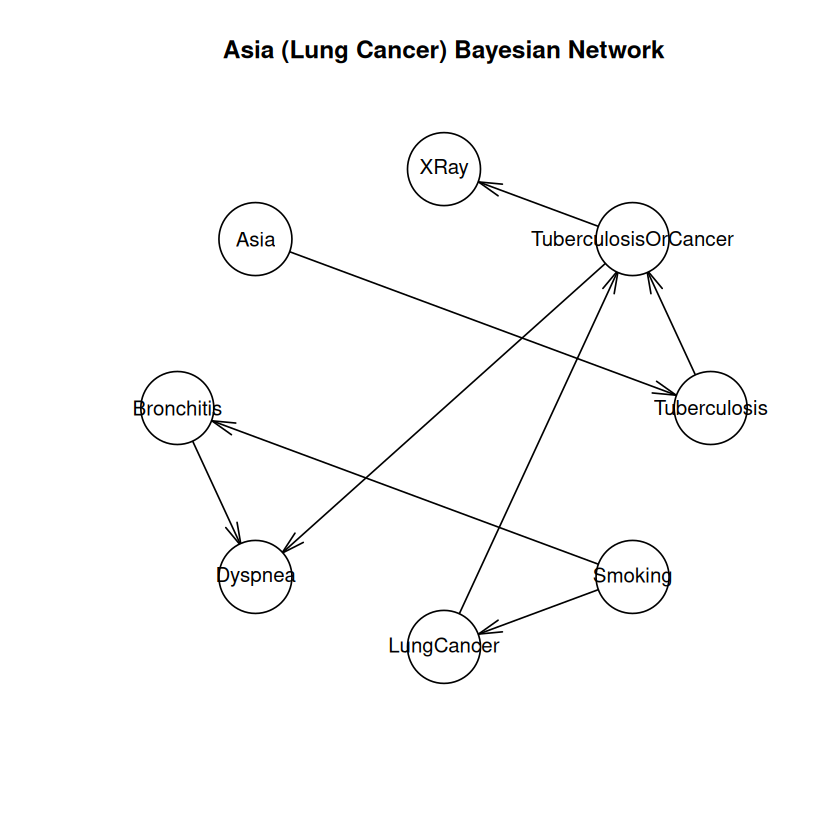

In [32]:
# ============================================================================
# CLASSIC BAYESIAN NETWORK: The Asia (Lung Cancer) Example
# ============================================================================
# Famous example from Lauritzen & Spiegelhalter (1988)
# Models relationships between: visit to Asia, smoking, tuberculosis, 
# lung cancer, bronchitis, and X-ray results
# ============================================================================

library(bnlearn)
library(gRain)

# ============================================================================
# 1. NETWORK STRUCTURE
# ============================================================================

# Variables:
# - Asia: Recent visit to Asia (yes/no)
# - Smoking: Person smokes (yes/no)
# - Tuberculosis: Has tuberculosis (yes/no) - caused by Asia visit
# - LungCancer: Has lung cancer (yes/no) - caused by smoking
# - Bronchitis: Has bronchitis (yes/no) - caused by smoking
# - TuberculosisOrCancer: Has either tuberculosis OR lung cancer (yes/no)
# - XRay: Chest X-ray is abnormal (yes/no) - caused by TB or cancer
# - Dyspnea: Shortness of breath (yes/no) - caused by TB/cancer or bronchitis

# Define the DAG structure
asia_dag <- model2network(paste0(
  "[Asia]",
  "[Smoking]",
  "[Tuberculosis|Asia]",
  "[LungCancer|Smoking]",
  "[Bronchitis|Smoking]",
  "[TuberculosisOrCancer|Tuberculosis:LungCancer]",
  "[XRay|TuberculosisOrCancer]",
  "[Dyspnea|TuberculosisOrCancer:Bronchitis]"
))

# Visualize the network
plot(asia_dag, main = "Asia (Lung Cancer) Bayesian Network")

# ============================================================================
# 2. CONDITIONAL PROBABILITY TABLES (CPTs)
# ============================================================================

# P(Asia) - Prior probability of visiting Asia
cpt_asia <- matrix(
  c(0.99, 0.01),  # 1% chance of visiting Asia
  ncol = 2,
  dimnames = list(NULL, c("no", "yes"))
)

# P(Smoking) - Prior probability of being a smoker
cpt_smoking <- matrix(
  c(0.5, 0.5),  # 50% are smokers
  ncol = 2,
  dimnames = list(NULL, c("no", "yes"))
)

# P(Tuberculosis | Asia) - TB is more common in Asia
cpt_tuberculosis <- matrix(
  c(0.99,  0.01,   # No Asia visit: 1% TB risk
    0.95,  0.05),  # Asia visit: 5% TB risk
  nrow = 2, ncol = 2, byrow = FALSE,
  dimnames = list(
    Tuberculosis = c("no", "yes"),
    Asia = c("no", "yes")
  )
)

# P(LungCancer | Smoking) - Lung cancer is caused by smoking
cpt_lungcancer <- matrix(
  c(0.99,  0.01,   # Non-smoker: 1% cancer risk
    0.90,  0.10),  # Smoker: 10% cancer risk
  nrow = 2, ncol = 2, byrow = FALSE,
  dimnames = list(
    LungCancer = c("no", "yes"),
    Smoking = c("no", "yes")
  )
)

# P(Bronchitis | Smoking) - Bronchitis is caused by smoking
cpt_bronchitis <- matrix(
  c(0.70,  0.30,   # Non-smoker: 30% bronchitis
    0.40,  0.60),  # Smoker: 60% bronchitis
  nrow = 2, ncol = 2, byrow = FALSE,
  dimnames = list(
    Bronchitis = c("no", "yes"),
    Smoking = c("no", "yes")
  )
)

# P(TuberculosisOrCancer | Tuberculosis, LungCancer)
# This is a deterministic OR gate
cpt_tuberc_or_cancer <- array(
  c(1.0, 0.0,   # TB=no, Cancer=no  → OR=no (100%)
    0.0, 1.0,   # TB=no, Cancer=yes → OR=yes (100%)
    0.0, 1.0,   # TB=yes, Cancer=no → OR=yes (100%)
    0.0, 1.0),  # TB=yes, Cancer=yes → OR=yes (100%)
  dim = c(2, 2, 2),
  dimnames = list(
    TuberculosisOrCancer = c("no", "yes"),
    LungCancer = c("no", "yes"),
    Tuberculosis = c("no", "yes")
  )
)

# P(XRay | TuberculosisOrCancer) - X-ray detects TB or cancer
cpt_xray <- matrix(
  c(0.95,  0.05,   # No TB/Cancer: 5% false positive
    0.02,  0.98),  # Has TB/Cancer: 98% detected
  nrow = 2, ncol = 2, byrow = FALSE,
  dimnames = list(
    XRay = c("no", "yes"),
    TuberculosisOrCancer = c("no", "yes")
  )
)

# P(Dyspnea | TuberculosisOrCancer, Bronchitis) - Shortness of breath
cpt_dyspnea <- array(
  c(0.90, 0.10,   # No TB/Cancer, No Bronchitis: 10% dyspnea
    0.20, 0.80,   # No TB/Cancer, Has Bronchitis: 80% dyspnea
    0.30, 0.70,   # Has TB/Cancer, No Bronchitis: 70% dyspnea
    0.10, 0.90),  # Has TB/Cancer, Has Bronchitis: 90% dyspnea
  dim = c(2, 2, 2),
  dimnames = list(
    Dyspnea = c("no", "yes"),
    Bronchitis = c("no", "yes"),
    TuberculosisOrCancer = c("no", "yes")
  )
)

# ============================================================================
# 3. FIT THE BAYESIAN NETWORK
# ============================================================================

asia_fitted <- custom.fit(asia_dag, list(
  Asia = cpt_asia,
  Smoking = cpt_smoking,
  Tuberculosis = cpt_tuberculosis,
  LungCancer = cpt_lungcancer,
  Bronchitis = cpt_bronchitis,
  TuberculosisOrCancer = cpt_tuberc_or_cancer,
  XRay = cpt_xray,
  Dyspnea = cpt_dyspnea
))

# View the CPTs
cat("\n=== CONDITIONAL PROBABILITY TABLES ===\n\n")
cat("P(Tuberculosis | Asia):\n")
print(asia_fitted$Tuberculosis)

cat("\nP(LungCancer | Smoking):\n")
print(asia_fitted$LungCancer)

cat("\nP(XRay | TuberculosisOrCancer):\n")
print(asia_fitted$XRay)

# ============================================================================
# 4. CONVERT TO gRain FOR INFERENCE
# ============================================================================

asia_junction <- as.grain(asia_fitted)

# ============================================================================
# 5. DIAGNOSTIC REASONING - MEDICAL DIAGNOSIS SCENARIOS
# ============================================================================

cat("\n")
cat(rep("=", 80), "\n", sep = "")
cat("                    MEDICAL DIAGNOSTIC SCENARIOS\n")
cat(rep("=", 80), "\n\n", sep = "")

# SCENARIO 1: Prior probabilities (no information)
cat("SCENARIO 1: No symptoms observed (prior probabilities)\n")
cat(rep("-", 79), "\n", sep = "")
prior_tb <- querygrain(asia_junction, "Tuberculosis")$Tuberculosis["yes"]
prior_cancer <- querygrain(asia_junction, "LungCancer")$LungCancer["yes"]
prior_bronc <- querygrain(asia_junction, "Bronchitis")$Bronchitis["yes"]
cat("P(Tuberculosis = yes) = ", round(prior_tb, 4), " (", 
    round(prior_tb*100, 2), "%)\n", sep="")
cat("P(LungCancer = yes)   = ", round(prior_cancer, 4), " (", 
    round(prior_cancer*100, 2), "%)\n", sep="")
cat("P(Bronchitis = yes)   = ", round(prior_bronc, 4), " (", 
    round(prior_bronc*100, 2), "%)\n", sep="")

# SCENARIO 2: Patient has dyspnea (shortness of breath)
cat("\n\nSCENARIO 2: Patient has shortness of breath\n")
cat(rep("-", 79), "\n", sep = "")
ev1 <- setEvidence(asia_junction, nodes = "Dyspnea", states = "yes")
result1 <- querygrain(ev1, c("Tuberculosis", "LungCancer", "Bronchitis"))
cat("Given: Dyspnea = yes\n\n")
cat("P(Tuberculosis = yes | Dyspnea) = ", 
    round(result1$Tuberculosis["yes"], 4), "\n", sep="")
cat("P(LungCancer = yes | Dyspnea)   = ", 
    round(result1$LungCancer["yes"], 4), "\n", sep="")
cat("P(Bronchitis = yes | Dyspnea)   = ", 
    round(result1$Bronchitis["yes"], 4), "\n", sep="")

# SCENARIO 3: Dyspnea AND abnormal X-ray
cat("\n\nSCENARIO 3: Patient has dyspnea AND abnormal X-ray\n")
cat(rep("-", 79), "\n", sep = "")
ev2 <- setEvidence(asia_junction, 
                   nodes = c("Dyspnea", "XRay"), 
                   states = c("yes", "yes"))
result2 <- querygrain(ev2, c("Tuberculosis", "LungCancer", "Bronchitis"))
cat("Given: Dyspnea = yes, XRay = yes\n\n")
cat("P(Tuberculosis = yes | Evidence) = ", 
    round(result2$Tuberculosis["yes"], 4), "\n", sep="")
cat("P(LungCancer = yes | Evidence)   = ", 
    round(result2$LungCancer["yes"], 4), "\n", sep="")
cat("P(Bronchitis = yes | Evidence)   = ", 
    round(result2$Bronchitis["yes"], 4), "\n", sep="")
cat("\nNote: X-ray greatly increases suspicion of TB or cancer!\n")

# SCENARIO 4: Adding smoking history
cat("\n\nSCENARIO 4: Dyspnea, abnormal X-ray, AND patient is a smoker\n")
cat(rep("-", 79), "\n", sep = "")
ev3 <- setEvidence(asia_junction,
                   nodes = c("Dyspnea", "XRay", "Smoking"),
                   states = c("yes", "yes", "yes"))
result3 <- querygrain(ev3, c("Tuberculosis", "LungCancer", "Bronchitis"))
cat("Given: Dyspnea = yes, XRay = yes, Smoking = yes\n\n")
cat("P(Tuberculosis = yes | Evidence) = ", 
    round(result3$Tuberculosis["yes"], 4), "\n", sep="")
cat("P(LungCancer = yes | Evidence)   = ", 
    round(result3$LungCancer["yes"], 4), "\n", sep="")
cat("P(Bronchitis = yes | Evidence)   = ", 
    round(result3$Bronchitis["yes"], 4), "\n", sep="")
cat("\nNote: Smoking history makes lung cancer more likely!\n")

# SCENARIO 5: "Explaining away" - Abnormal X-ray + visited Asia recently
cat("\n\nSCENARIO 5: Abnormal X-ray + recent visit to Asia\n")
cat(rep("-", 79), "\n", sep = "")
ev4 <- setEvidence(asia_junction,
                   nodes = c("XRay", "Asia"),
                   states = c("yes", "yes"))
result4 <- querygrain(ev4, c("Tuberculosis", "LungCancer"))
cat("Given: XRay = yes, Asia visit = yes\n\n")
cat("P(Tuberculosis = yes | Evidence) = ", 
    round(result4$Tuberculosis["yes"], 4), "\n", sep="")
cat("P(LungCancer = yes | Evidence)   = ", 
    round(result4$LungCancer["yes"], 4), "\n", sep="")
cat("\nNote: Asia visit makes TB more likely, 'explaining away' the X-ray!\n")

# SCENARIO 6: Non-smoker with dyspnea and X-ray
cat("\n\nSCENARIO 6: NON-smoker with dyspnea and abnormal X-ray\n")
cat(rep("-", 79), "\n", sep = "")
ev5 <- setEvidence(asia_junction,
                   nodes = c("Dyspnea", "XRay", "Smoking"),
                   states = c("yes", "yes", "no"))
result5 <- querygrain(ev5, c("Tuberculosis", "LungCancer"))
cat("Given: Dyspnea = yes, XRay = yes, Smoking = no\n\n")
cat("P(Tuberculosis = yes | Evidence) = ", 
    round(result5$Tuberculosis["yes"], 4), "\n", sep="")
cat("P(LungCancer = yes | Evidence)   = ", 
    round(result5$LungCancer["yes"], 4), "\n", sep="")
cat("\nNote: Non-smoker: TB becomes more likely relative to lung cancer!\n")

cat("\n")
cat(rep("=", 80), "\n", sep = "")



=== WORKING WITH BUILT-IN ASIA DATASET ===

Dataset dimensions: 5000 rows, 8 columns

Variable names in the dataset:
[1] "A" "S" "T" "L" "B" "E" "X" "D"

First few rows:
   A   S   T  L   B   E   X   D
1 no yes  no no yes  no  no yes
2 no yes  no no  no  no  no  no
3 no  no yes no  no yes yes yes
4 no  no  no no yes  no  no yes
5 no  no  no no  no  no  no yes
6 no yes  no no  no  no  no yes

Variable meanings:
  A = Asia (visit to Asia)
  S = Smoking
  T = Tuberculosis
  L = Lung cancer
  B = Bronchitis
  E = Either tuberculosis or lung cancer
  X = X-ray result
  D = Dyspnea (shortness of breath)

True Asia network structure:

  Random/Generated Bayesian network

  model:
   [A][S][B|S][L|S][T|A][E|L:T][D|B:E][X|E] 
  nodes:                                 8 
  arcs:                                  8 
    undirected arcs:                     0 
    directed arcs:                       8 
  average markov blanket size:           2.50 
  average neighbourhood size:            2.00 
  

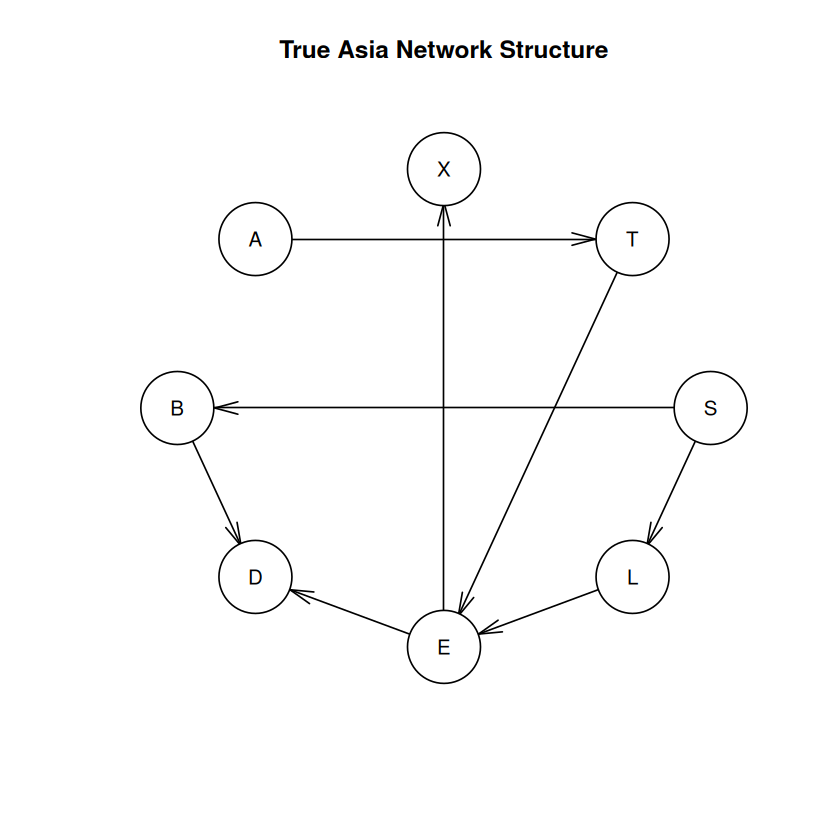



=== COMPARING TRUE vs LEARNED STRUCTURE ===
$tp
[1] 7

$fp
[1] 0

$fn
[1] 1


Interpretation:
  • True Positives (tp): 7 - Correct edges found
  • False Positives (fp): 0 - Extra edges (shouldn't be there)
  • False Negatives (fn): 1 - Missing edges (should be there)


=== LEARNED CONDITIONAL PROBABILITY TABLES ===

P(T | A) - Tuberculosis given Asia visit:

  Parameters of node T (multinomial distribution)

Conditional probability table:
     no    yes 
0.9912 0.0088 

P(L | S) - Lung cancer given Smoking:

  Parameters of node L (multinomial distribution)

Conditional probability table:
 
     S
L             no        yes
  no  0.98631791 0.88230616
  yes 0.01368209 0.11769384

P(X | E) - X-ray given TB or Cancer:

  Parameters of node X (multinomial distribution)

Conditional probability table:
 
     E
X              no         yes
  no  0.956587473 0.005405405
  yes 0.043412527 0.994594595


              DIAGNOSTIC INFERENCE WITH LEARNED NETWORK

SCENARIO 1: Prior probabilitie

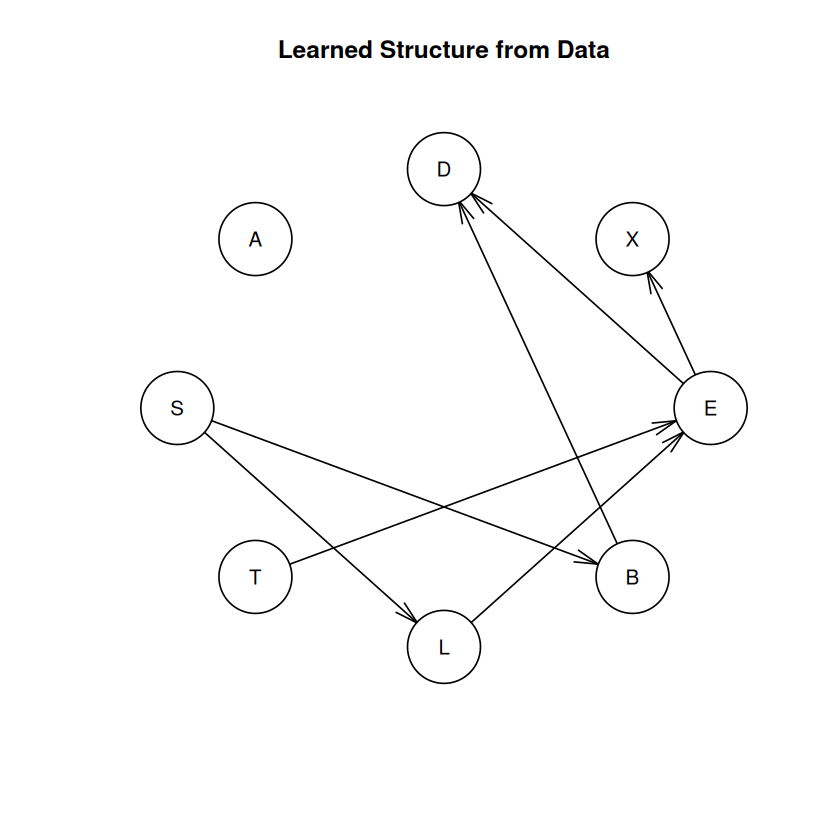



=== COMPARING DIFFERENT STRUCTURE LEARNING ALGORITHMS ===

Algorithm comparison (BIC scores, higher is better):
  Hill-Climbing:  -11107.29 
  Tabu Search:    -11107.29 
  Grow-Shrink:    -12526.5 

Accuracy compared to true structure:
  Hill-Climbing:
$tp
[1] 7

$fp
[1] 0

$fn
[1] 1


  Tabu Search:
$tp
[1] 7

$fp
[1] 0

$fn
[1] 1


  Grow-Shrink:
$tp
[1] 3

$fp
[1] 1

$fn
[1] 5



=== KEY INSIGHTS ===
1. Structure learning can recover causal relationships from data
2. Different algorithms may learn slightly different structures
3. The learned network enables probabilistic inference about diseases
4. 'Explaining away' phenomenon: knowing one cause reduces belief in others
5. The Asia network demonstrates diagnostic reasoning in medicine


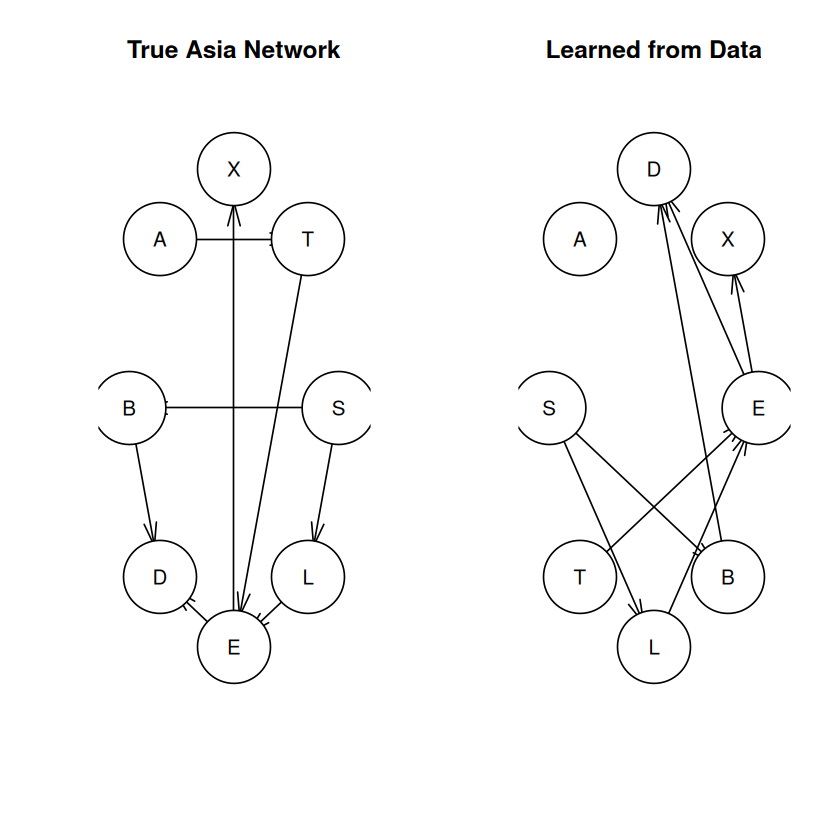

In [33]:
# ============================================================================
# USING THE BUILT-IN ASIA DATASET (Correct Variable Names)
# ============================================================================

library(bnlearn)
library(gRain)

cat("\n=== WORKING WITH BUILT-IN ASIA DATASET ===\n\n")

# Load the built-in dataset
data(asia)

# Check the data structure
cat("Dataset dimensions:", nrow(asia), "rows,", ncol(asia), "columns\n\n")
cat("Variable names in the dataset:\n")
print(colnames(asia))

cat("\nFirst few rows:\n")
print(head(asia))

cat("\nVariable meanings:\n")
cat("  A = Asia (visit to Asia)\n")
cat("  S = Smoking\n")
cat("  T = Tuberculosis\n")
cat("  L = Lung cancer\n")
cat("  B = Bronchitis\n")
cat("  E = Either tuberculosis or lung cancer\n")
cat("  X = X-ray result\n")
cat("  D = Dyspnea (shortness of breath)\n\n")

# ============================================================================
# 1. DEFINE THE TRUE ASIA NETWORK STRUCTURE (with correct names)
# ============================================================================

# Use the correct variable names from the dataset
true_asia_dag <- model2network(paste0(
  "[A]",
  "[S]",
  "[T|A]",
  "[L|S]",
  "[B|S]",
  "[E|T:L]",
  "[X|E]",
  "[D|E:B]"
))

cat("True Asia network structure:\n")
print(true_asia_dag)
plot(true_asia_dag, main = "True Asia Network Structure")

# ============================================================================
# 2. LEARN NETWORK FROM DATA
# ============================================================================

# Learn the structure using hill-climbing
learned_dag <- hc(asia)

cat("\n\nLearned network structure:\n")
print(learned_dag)
plot(learned_dag, main = "Learned Structure from Data")

# ============================================================================
# 3. COMPARE TRUE VS LEARNED STRUCTURE
# ============================================================================

cat("\n\n=== COMPARING TRUE vs LEARNED STRUCTURE ===\n")
comparison <- compare(true_asia_dag, learned_dag)
print(comparison)

cat("\nInterpretation:\n")
cat("  • True Positives (tp):", comparison$tp, "- Correct edges found\n")
cat("  • False Positives (fp):", comparison$fp, "- Extra edges (shouldn't be there)\n")
cat("  • False Negatives (fn):", comparison$fn, "- Missing edges (should be there)\n")

# ============================================================================
# 4. FIT THE NETWORK WITH LEARNED STRUCTURE
# ============================================================================

# Fit CPTs using Maximum Likelihood Estimation
fitted_asia <- bn.fit(learned_dag, asia)

cat("\n\n=== LEARNED CONDITIONAL PROBABILITY TABLES ===\n\n")
cat("P(T | A) - Tuberculosis given Asia visit:\n")
print(fitted_asia$T)

cat("\nP(L | S) - Lung cancer given Smoking:\n")
print(fitted_asia$L)

cat("\nP(X | E) - X-ray given TB or Cancer:\n")
print(fitted_asia$X)

# ============================================================================
# 5. INFERENCE WITH THE LEARNED NETWORK
# ============================================================================

# Convert to gRain
asia_junction <- as.grain(fitted_asia)

cat("\n\n")
cat(rep("=", 80), "\n", sep = "")
cat("              DIAGNOSTIC INFERENCE WITH LEARNED NETWORK\n")
cat(rep("=", 80), "\n\n", sep = "")

# SCENARIO 1: No evidence (priors)
cat("SCENARIO 1: Prior probabilities\n")
cat(rep("-", 79), "\n", sep = "")
priors <- querygrain(asia_junction, c("T", "L", "B"))
cat("P(Tuberculosis = yes) =", round(priors$T["yes"], 4), "\n")
cat("P(LungCancer = yes)   =", round(priors$L["yes"], 4), "\n")
cat("P(Bronchitis = yes)   =", round(priors$B["yes"], 4), "\n")

# SCENARIO 2: Patient has dyspnea
cat("\n\nSCENARIO 2: Patient has shortness of breath\n")
cat(rep("-", 79), "\n", sep = "")
ev1 <- setEvidence(asia_junction, nodes = "D", states = "yes")
result1 <- querygrain(ev1, c("T", "L", "B"))
cat("Given: Dyspnea = yes\n\n")
cat("P(Tuberculosis = yes | D = yes) =", round(result1$T["yes"], 4), "\n")
cat("P(LungCancer = yes | D = yes)   =", round(result1$L["yes"], 4), "\n")
cat("P(Bronchitis = yes | D = yes)   =", round(result1$B["yes"], 4), "\n")

# SCENARIO 3: Dyspnea AND abnormal X-ray
cat("\n\nSCENARIO 3: Dyspnea AND abnormal X-ray\n")
cat(rep("-", 79), "\n", sep = "")
ev2 <- setEvidence(asia_junction, nodes = c("D", "X"), states = c("yes", "yes"))
result2 <- querygrain(ev2, c("T", "L", "B"))
cat("Given: Dyspnea = yes, X-ray = yes\n\n")
cat("P(Tuberculosis = yes | Evidence) =", round(result2$T["yes"], 4), "\n")
cat("P(LungCancer = yes | Evidence)   =", round(result2$L["yes"], 4), "\n")
cat("P(Bronchitis = yes | Evidence)   =", round(result2$B["yes"], 4), "\n")
cat("\nNote: X-ray greatly increases suspicion of TB or lung cancer!\n")

# SCENARIO 4: X-ray + Smoking history
cat("\n\nSCENARIO 4: Abnormal X-ray + Patient smokes\n")
cat(rep("-", 79), "\n", sep = "")
ev3 <- setEvidence(asia_junction, nodes = c("X", "S"), states = c("yes", "yes"))
result3 <- querygrain(ev3, c("T", "L"))
cat("Given: X-ray = yes, Smoking = yes\n\n")
cat("P(Tuberculosis = yes | Evidence) =", round(result3$T["yes"], 4), "\n")
cat("P(LungCancer = yes | Evidence)   =", round(result3$L["yes"], 4), "\n")
cat("\nNote: Smoking makes lung cancer more likely!\n")

# SCENARIO 5: Explaining away - X-ray + Asia visit
cat("\n\nSCENARIO 5: Explaining Away - X-ray + Asia visit\n")
cat(rep("-", 79), "\n", sep = "")
ev4 <- setEvidence(asia_junction, nodes = c("X", "A"), states = c("yes", "yes"))
result4 <- querygrain(ev4, c("T", "L"))
cat("Given: X-ray = yes, Asia visit = yes\n\n")
cat("P(Tuberculosis = yes | Evidence) =", round(result4$T["yes"], 4), "\n")
cat("P(LungCancer = yes | Evidence)   =", round(result4$L["yes"], 4), "\n")
cat("\nNote: Asia visit 'explains away' the X-ray, making TB more likely!\n")

# SCENARIO 6: Non-smoker with symptoms
cat("\n\nSCENARIO 6: Non-smoker with dyspnea and abnormal X-ray\n")
cat(rep("-", 79), "\n", sep = "")
ev5 <- setEvidence(asia_junction, nodes = c("D", "X", "S"), 
                   states = c("yes", "yes", "no"))
result5 <- querygrain(ev5, c("T", "L"))
cat("Given: Dyspnea = yes, X-ray = yes, Smoking = no\n\n")
cat("P(Tuberculosis = yes | Evidence) =", round(result5$T["yes"], 4), "\n")
cat("P(LungCancer = yes | Evidence)   =", round(result5$L["yes"], 4), "\n")
cat("\nNote: Non-smoker makes lung cancer less likely!\n")

cat("\n")
cat(rep("=", 80), "\n", sep = "")

# ============================================================================
# 6. VISUALIZE BOTH NETWORKS SIDE BY SIDE
# ============================================================================

par(mfrow = c(1, 2))
plot(true_asia_dag, main = "True Asia Network")
plot(learned_dag, main = "Learned from Data")
par(mfrow = c(1, 1))

# ============================================================================
# 7. STRUCTURE LEARNING WITH DIFFERENT ALGORITHMS
# ============================================================================

cat("\n\n=== COMPARING DIFFERENT STRUCTURE LEARNING ALGORITHMS ===\n\n")

# Hill-climbing (already done)
hc_net <- hc(asia)
hc_score <- score(hc_net, asia, type = "bic")

# Tabu search
tabu_net <- tabu(asia)
tabu_score <- score(tabu_net, asia, type = "bic")

# Grow-shrink (constraint-based)
gs_net <- gs(asia)
gs_score <- score(gs_net, asia, type = "bic")

cat("Algorithm comparison (BIC scores, higher is better):\n")
cat("  Hill-Climbing: ", round(hc_score, 2), "\n")
cat("  Tabu Search:   ", round(tabu_score, 2), "\n")
cat("  Grow-Shrink:   ", round(gs_score, 2), "\n\n")

# Compare each learned structure to the true structure
cat("Accuracy compared to true structure:\n")
cat("  Hill-Climbing:\n")
print(compare(true_asia_dag, hc_net))
cat("\n  Tabu Search:\n")
print(compare(true_asia_dag, tabu_net))
cat("\n  Grow-Shrink:\n")
print(compare(true_asia_dag, gs_net))

# ============================================================================
# 8. KEY INSIGHTS
# ============================================================================

cat("\n\n=== KEY INSIGHTS ===\n")
cat("1. Structure learning can recover causal relationships from data\n")
cat("2. Different algorithms may learn slightly different structures\n")
cat("3. The learned network enables probabilistic inference about diseases\n")
cat("4. 'Explaining away' phenomenon: knowing one cause reduces belief in others\n")
cat("5. The Asia network demonstrates diagnostic reasoning in medicine\n")